В этом ноутбуке попробуем разобраться и собрать код, позволяющий в круговой диаграмме учитывать угловые размеры объекта.

Для этого возьмём искуственный пример из `artificial_example.ipynb`, построем по нему osm_object для изображения, а затем доработаем круговую диаграмму.

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
import sys
sys.path.append('..')
from rectangles_drawing import calculate_one_pixels_diffs
from osm_object import Image_OSM_object

from utils import read_pickle, dump_pickle

### Копипастим искусственный пример

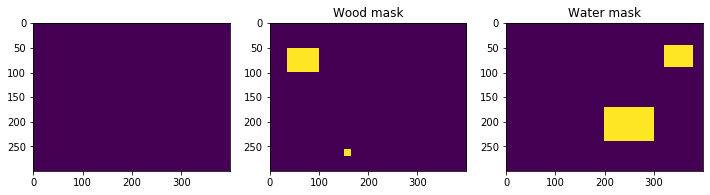

In [3]:
mask = np.zeros((300, 400))

wood_mask = mask.copy()
wood_mask[50:100, 35:100] = 1
wood_mask[255:270, 150:165] = 1

water_mask = mask.copy()
water_mask[170:240, 200:300] = 1
water_mask[45:90, 320:380] = 1


plt.figure(figsize=(12, 9))

plt.subplot(131)
plt.imshow(mask)

plt.subplot(132)
plt.title('Wood mask')
plt.imshow(wood_mask)

plt.subplot(133)
plt.title('Water mask')
plt.imshow(water_mask)

plt.show()

In [4]:
H, W = 300, 400

def rectangle_to_coords(rectangle, right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon):
    x1, x2, y1, y2 = rectangle
    
    one_pixel_lat_diff, one_pixel_lon_diff = calculate_one_pixels_diffs(right_top_lat, right_top_lon, 
                                                                    left_bottom_lat, left_bottom_lon, (H, W))
    
    minlat = right_top_lat - (x2 * one_pixel_lat_diff)
    maxlat = right_top_lat - (x1 * one_pixel_lat_diff)
    minlon = left_bottom_lon + (y1 * one_pixel_lon_diff)
    maxlon = left_bottom_lon + (y2 * one_pixel_lon_diff)
    
    return minlat, maxlat, minlon, maxlon

In [5]:
# right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon отберём у какой-нибудь существующей картинки
corners_folder = '../dataset/corners'
corners = read_pickle(os.path.join(corners_folder, '224.pickle'))

right_top_lat = corners['right_top_lat']
right_top_lon = corners['right_top_lon']
left_bottom_lat = corners['left_bottom_lat']
left_bottom_lon = corners['left_bottom_lon']

In [6]:
def predict_one(autoencoder, img, thresh):
    return autoencoder.predict(np.array([img / 255.]).reshape(([1] + list(img.shape))))[0] >= thresh


def mask_to_rectangles(mask):
    visited = np.zeros(mask.shape[:2], dtype=int)
    queue = []
    rectangles = []
    
    queue_idx = 0

    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            # первая непосещённая вершина
            if visited[x][y] == 0 and mask[x][y]:
                cur_vertex = (x, y)
            else:
                continue
        
            queue.append(cur_vertex)
        
            def bfs(queue_idx):
                min_x, max_x, min_y, max_y = None, None, None, None

                while len(queue) != queue_idx:
                    v = queue[queue_idx]
                    queue_idx += 1

                    x, y = v
                    if visited[x][y] == 1:
                        continue
                    visited[x][y] = 1

                    if min_x is None or x < min_x:
                        min_x = x
                    if max_x is None or x > max_x:
                        max_x = x
                    if min_y is None or y < min_y:
                        min_y = y
                    if max_y is None or y > max_y:
                        max_y = y

                    # рассматриваем все соседние непосещённые вершины
                    left = (x, y - 1)
                    right = (x, y + 1)
                    top = (x - 1, y)
                    bottom = (x + 1, y)

                    def visit_vertex(x, y):
                        if x >= 0 and y >= 0 and x < mask.shape[0] and y < mask.shape[1] and visited[x][y] == 0\
                            and mask[x][y]:
                                queue.append((x, y))

                    visit_vertex(*left)
                    visit_vertex(*right)
                    visit_vertex(*top)
                    visit_vertex(*bottom)

                return queue_idx, queue, visited, min_x, max_x, min_y, max_y

            queue_idx, queue, visited, min_x, max_x, min_y, max_y = bfs(queue_idx)
            if min_x is not None and max_x is not None and min_y is not None and max_y is not None:
                rectangles.append((min_x, max_x, min_y, max_y))

    return rectangles


In [7]:
rectangles_wood = mask_to_rectangles(wood_mask)
print(rectangles_wood)
rectangles_water = mask_to_rectangles(water_mask)
print(rectangles_water)

[(50, 99, 35, 99), (255, 269, 150, 164)]
[(45, 89, 320, 379), (170, 239, 200, 299)]


In [8]:
bounds = []
tags = []

for r in rectangles_wood:
    minlat, maxlat, minlon, maxlon = rectangle_to_coords(r, right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon)
    bounds.append({'maxlon': maxlon, 'minlat': minlat, 'minlon': minlon, 'maxlat': maxlat})
    tags.append('wood')
    
for r in rectangles_water:
    minlat, maxlat, minlon, maxlon = rectangle_to_coords(r, right_top_lat, right_top_lon, left_bottom_lat, left_bottom_lon)
    bounds.append({'maxlon': maxlon, 'minlat': minlat, 'minlon': minlon, 'maxlat': maxlat})
    tags.append('water')

In [9]:
rectangles = [rectangles_wood + rectangles_water]
rectangles

[[(50, 99, 35, 99),
  (255, 269, 150, 164),
  (45, 89, 320, 379),
  (170, 239, 200, 299)]]

### Строим osm-object

In [10]:
img_shape = (H, W)

img_osm = Image_OSM_object(
    img_shape,
    right_top_lat,
    right_top_lon,
    left_bottom_lat,
    left_bottom_lon,
    bounds,
    tags
)

### Circle diagram

In [11]:
from circle_diagram import calculate_sectors_count, create_circle_diagram
from circle_diagram import Image_circle_diagrams

In [12]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)

img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)

In [13]:
img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=False, with_angle_penalty=False)

In [14]:
img_cds_1 = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=False, with_angle_penalty=True)

### Теперь добавим диаграмму агента, чтобы было с чем сравнивать

In [15]:
points = read_pickle('../dataset/100_random_points.pickle')
points_to_centers_6_8 = read_pickle('../dataset/100_points_to_cell_centers_48cells_6x8.pickle')

In [16]:
agent_cd = create_circle_diagram(sectors_count, points[0][::-1], img_osm, with_angle_penalty=False)
agent_cd_1 = create_circle_diagram(sectors_count, points[0][::-1], img_osm, with_angle_penalty=True)

In [17]:
from circle_diagram import calculate_penalty_for_diagrams

In [18]:
%%time
penalties = []

for i in range(len(img_cds.circle_diagrams)):
    penalties.append(calculate_penalty_for_diagrams(img_cds.circle_diagrams[i].sectors, agent_cd.sectors))
    
# Добавл. 1e-8 чтобы не было нулей
similaryties = np.max(penalties) - penalties + 1e-8

probs = similaryties / similaryties.sum()

print(max(probs))
print(min(probs))

0.053216454336125034
1.1462887309634625e-12
CPU times: user 31.6 ms, sys: 0 ns, total: 31.6 ms
Wall time: 31.2 ms


In [19]:
%%time
penalties_1 = []

for i in range(len(img_cds_1.circle_diagrams)):
    penalties_1.append(calculate_penalty_for_diagrams(img_cds_1.circle_diagrams[i].sectors, agent_cd_1.sectors))
    
# Добавл. 1e-8 чтобы не было нулей
similaryties_1 = np.max(penalties_1) - penalties_1 + 1e-8

probs_1 = similaryties_1 / similaryties_1.sum()

print(max(probs_1))
print(min(probs_1))

0.05297249390307912
1.1449759735167882e-12
CPU times: user 31.6 ms, sys: 0 ns, total: 31.6 ms
Wall time: 31.3 ms


In [20]:
def calculate_cells_probs(img_cds, agent_cd):
    """
    only fast version
    """
    penalties = []
    
    for i in range(len(img_cds.center_points)):
#         penalties.append(img_cds.fast_diagrams[i].dist_to(agent_cd.fast_diagram))
        penalties.append(calculate_penalty_for_diagrams(img_cds.circle_diagrams[i].sectors, agent_cd.sectors))
        
    # Добавл. 1e-8 чтобы не было нулей
    similaryties = np.max(penalties) - penalties + 1e-8

    return similaryties / similaryties.sum()

In [21]:
def find_center_point_id(center_points, agent_point):
    for i in range(len(center_points)):
        if center_points[i] == agent_point:
            return i

In [22]:
def is_in_one_of_max_k(cell_probs, center_point_id, max_k):
    is_ok_for_different_k = []
    
    argsort = np.argsort(cell_probs)[::-1]
    for k in range(0, max_k):
        if argsort[k] == center_point_id:
            is_ok_for_different_k += [True for _ in range(max_k - k)]
            break
        else:
            is_ok_for_different_k.append(False)
        
    return is_ok_for_different_k

In [23]:
def calculate_precision_k_for_one(img_cds, img_cds_1, max_k):
    
    is_in_k_one_image = []
    is_in_k_one_image_1 = []
    
    for agent_point in points:
        agent_cd = create_circle_diagram(sectors_count, agent_point[::-1], img_osm, with_angle_penalty=False)
#         agent_cd.make_fast()
        agent_cd_1 = create_circle_diagram(sectors_count, agent_point[::-1], img_osm, with_angle_penalty=True)
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        cell_probs_1 = calculate_cells_probs(img_cds_1, agent_cd_1)
        
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers_6_8[agent_point][::-1])

        is_in_k_one_point = is_in_one_of_max_k(cell_probs, center_point_id, max_k)
        is_in_k_one_image.append(is_in_k_one_point)
        
        is_in_k_one_point_1 = is_in_one_of_max_k(cell_probs_1, center_point_id, max_k)
        is_in_k_one_image_1.append(is_in_k_one_point_1)
        
    return is_in_k_one_image, is_in_k_one_image_1

In [24]:
%%time
is_in_k, is_in_k_1 = calculate_precision_k_for_one(img_cds, img_cds_1, max_k=48)

CPU times: user 7.05 s, sys: 2.31 ms, total: 7.05 s
Wall time: 7.05 s


In [25]:
is_in_k = np.array(is_in_k)
is_in_k_1 = np.array(is_in_k_1)

In [26]:
print(is_in_k[:, 0].sum() / is_in_k.shape[0])
print(is_in_k_1[:, 0].sum() / is_in_k_1.shape[0])

0.77
0.78


In [27]:
print(is_in_k[:, 1].sum() / is_in_k.shape[0])
print(is_in_k_1[:, 1].sum() / is_in_k_1.shape[0])

0.84
0.84


In [28]:
print(is_in_k[:, 2].sum() / is_in_k.shape[0])
print(is_in_k_1[:, 2].sum() / is_in_k_1.shape[0])

0.87
0.87


In [29]:
print(is_in_k[:, 3].sum() / is_in_k.shape[0])
print(is_in_k_1[:, 3].sum() / is_in_k_1.shape[0])

0.87
0.87


In [30]:
print(is_in_k[:, 4].sum() / is_in_k.shape[0])
print(is_in_k_1[:, 4].sum() / is_in_k_1.shape[0])

0.87
0.87


In [31]:
print(is_in_k[:, 10].sum() / is_in_k.shape[0])
print(is_in_k_1[:, 10].sum() / is_in_k_1.shape[0])

0.89
0.89
